In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_model_summary import summary
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
from pathlib import Path
import h5py
import matplotlib.pyplot as plt

In [2]:
MODEL_PATH = "results_009_gn_lang_classification__dropout_0.6__fc_dropout_0.5/LangIdCNN_Mean2_FCD/retrained-wav2vec_features-z_0_checkpoints/1000.pt"

In [3]:
%ls results_009_gn_lang_classification__dropout_0.6__fc_dropout_0.5/LangIdCNN_Mean2_FCD/retrained-wav2vec_features-z_0_checkpoints/1000.pt

results_009_gn_lang_classification__dropout_0.6__fc_dropout_0.5/LangIdCNN_Mean2_FCD/retrained-wav2vec_features-z_0_checkpoints/1000.pt


In [4]:
class LangIdCNN_Mean2_FCD(nn.Module):
    def __init__(self):
        super(LangIdCNN_Mean2_FCD, self).__init__()
        
        self.conv0 = nn.Conv1d(in_channels=512, out_channels=3, kernel_size=1)
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3)
        self.drop1 = nn.Dropout(p=dropout_p)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3)
        self.drop2 = nn.Dropout(p=dropout_p)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop3 = nn.Dropout(p=dropout_p)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop4 = nn.Dropout(p=dropout_p)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.drop5 = nn.Dropout(p=fc_dropout_p)

        self.lin6 = nn.Linear(in_features=9, out_features=3)
        
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        x = self.conv0(x)
        
        x = self.conv1(x)
        x = F.elu(x)
        x = self.drop1(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = F.elu(x)
        x = self.drop2(x)
        x = self.pool2(x)
        
        v1 = torch.mean(x, dim=2)
        
        x = self.conv3(x)
        x = F.elu(x)
        x = self.drop3(x)
        x = self.pool3(x)
        
        v2 = torch.mean(x, dim=2)
        
        x = self.conv4(x)
        x = F.elu(x)
        x = self.drop4(x)
        x = self.pool4(x)
        
        v3 = torch.mean(x, dim=2)
        
        v = torch.cat((v1, v2, v3), axis=1)
        v = self.drop5(v)
        
        x = self.lin6(v)
        
        return v, x

In [5]:
checkpoint_data = torch.load(MODEL_PATH)

epoch = checkpoint_data['epoch']
fold_id = checkpoint_data['fold_id']
feature_name = checkpoint_data['feature_name']
model_name = checkpoint_data['model_name']
dropout_p = checkpoint_data['dropout_p']
fc_dropout_p = checkpoint_data['fc_dropout_p']

model_state_dict = checkpoint_data['model_state_dict']
optimizer_state_dict = checkpoint_data['optimizer_state_dict']
print(f"Loaded checkpoint: \n\tmodel_name: {model_name}\n\tfeature_name: {feature_name}\n\tfold_id: {fold_id}\n\tepoch: {epoch}")


Loaded checkpoint: 
	model_name: LangIdCNN_Mean2_FCD
	feature_name: retrained-wav2vec_features-z
	fold_id: 0
	epoch: 1000


In [6]:
model = LangIdCNN_Mean2_FCD()
model.load_state_dict(model_state_dict)
model.eval()

LangIdCNN_Mean2_FCD(
  (conv0): Conv1d(512, 3, kernel_size=(1,), stride=(1,))
  (conv1): Conv1d(3, 1, kernel_size=(3,), stride=(1,))
  (drop1): Dropout(p=0.6, inplace=False)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (drop2): Dropout(p=0.6, inplace=False)
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (drop3): Dropout(p=0.6, inplace=False)
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv4): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (drop4): Dropout(p=0.6, inplace=False)
  (pool4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (drop5): Dropout(p=0.5, inplace=False)
  (lin6): Linear(in_features=9, out_features=3, bias=True)
)

In [7]:
def load_features(audio_files, features_input_dir):
    id_list = []
    features_list = []

    for audio_file_name in audio_files:
        feature_file_name = audio_file_name.replace(".wav", ".h5context")
        feature_path = Path(features_input_dir) / feature_file_name
        with h5py.File(feature_path, 'r') as f:
            features_shape = f['info'][1:].astype(int)
            features = np.array(f['features'][:]).reshape(features_shape)
            # features = pool_feature_last_seq(features)
            features_list.append(features)
    return features_list

In [8]:
audio_files = [
    'b7edaec9-c399-4008-a84e-f607d903b83f.wav',
    'e9c1df2d-b51c-460a-8758-3de53061003c.wav',
    'c7b8e8ef-18e8-4c13-8f77-aec9f8be694d.wav',
    '51feb7a4-4dbb-4210-b18f-cec37c88f327.wav',
    'fd565bb2-a392-4ad2-837c-6a84dd404bf9.wav',
    'fce6e8bd-2f64-438b-8569-052f6783bcb2.wav',
]


AUDIO_DIR = '/media/xtrem/data/experiments/nicolingua-0001-language-id/audio_samples'
FEATURE_DIRS = [
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/wav2vec_features-c',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/wav2vec_features-z',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/retrained-wav2vec_features-c',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/retrained-wav2vec_features-z'
]

In [9]:
data = np.array(load_features(audio_files, FEATURE_DIRS[0]))

In [10]:
data.shape

(6, 2998, 512)

In [19]:
def visualize_attention(x, class_index):
    data_tensor = torch.tensor(x)
    data_tensor.requires_grad_(True)
    v, logits = model(data_tensor)
    print(logits.shape)

    g = torch.autograd.grad(logits[:, class_index], data_tensor)

    plt.figure(figsize=(20, 10))

    g_np = g[0].detach().numpy()
    np.mean(g_np, axis=2).shape
    plt.plot(np.max(np.abs(g_np), axis=2).flatten())

torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])


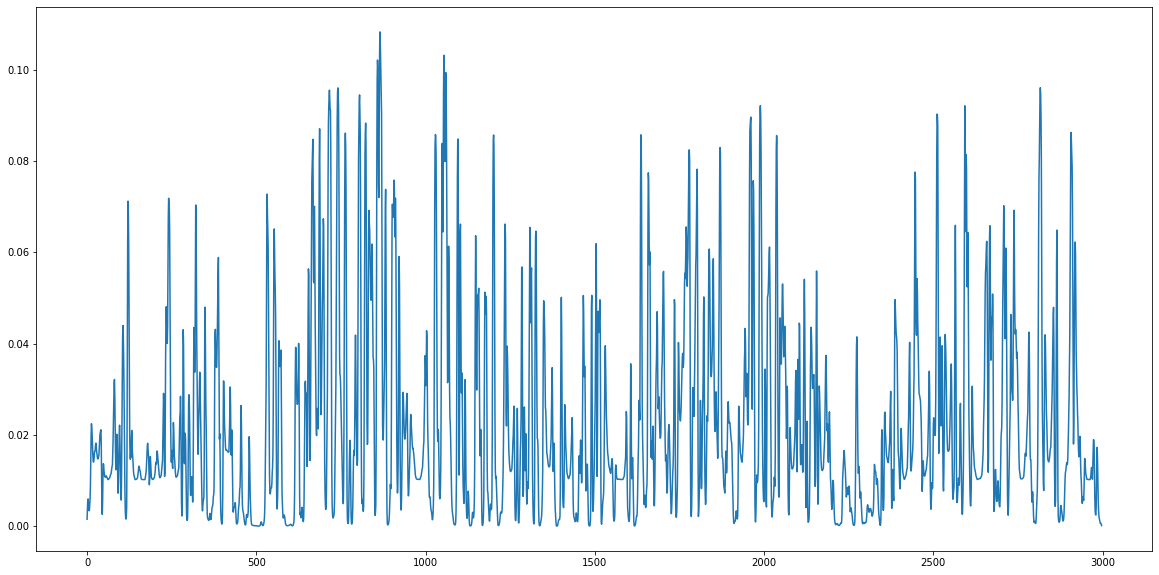

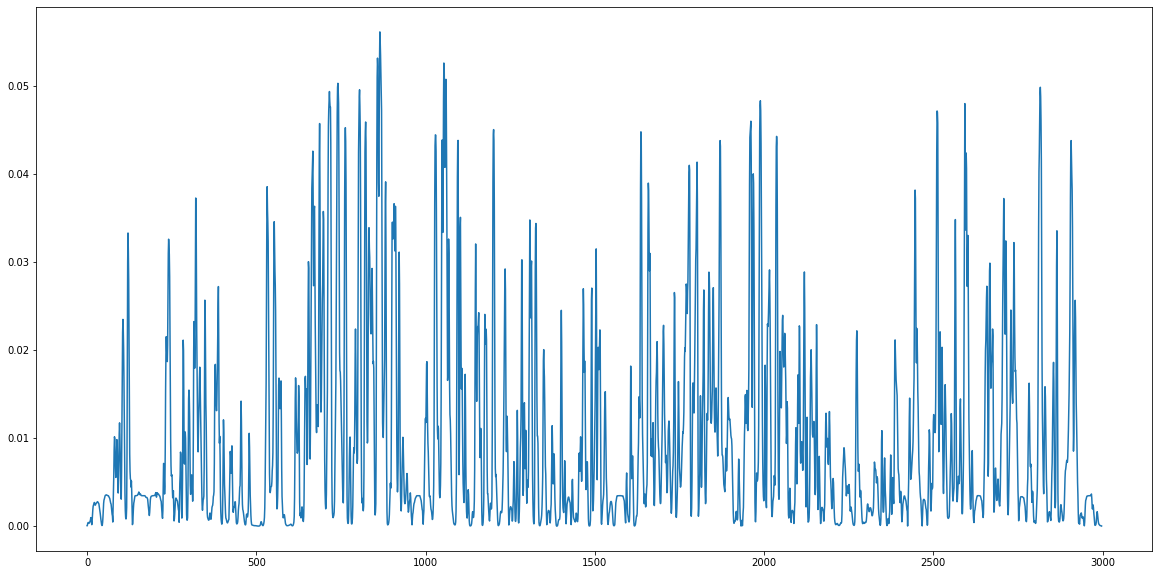

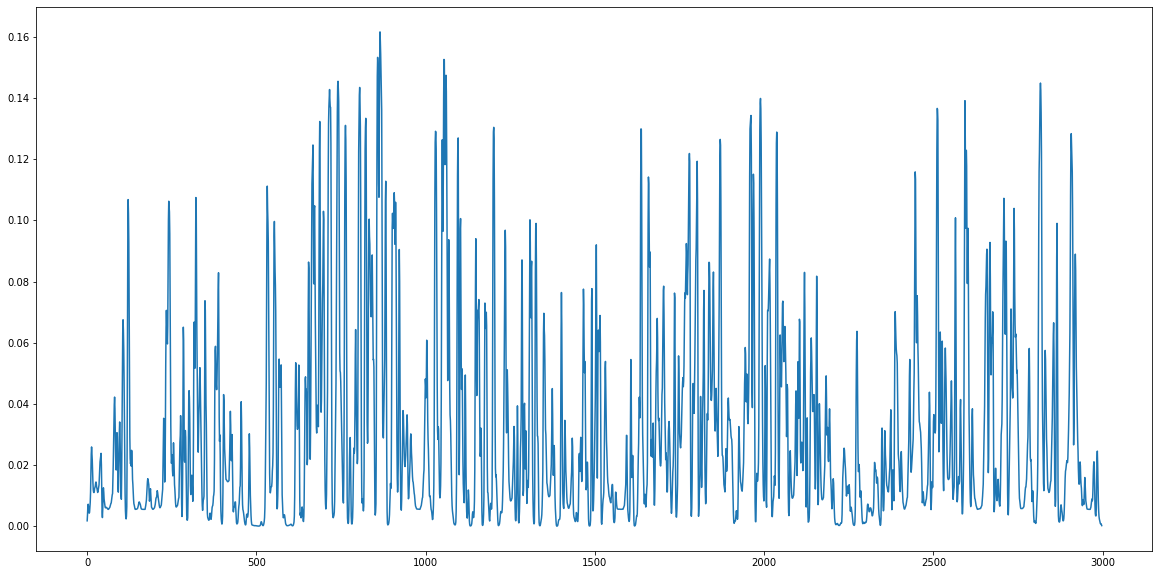

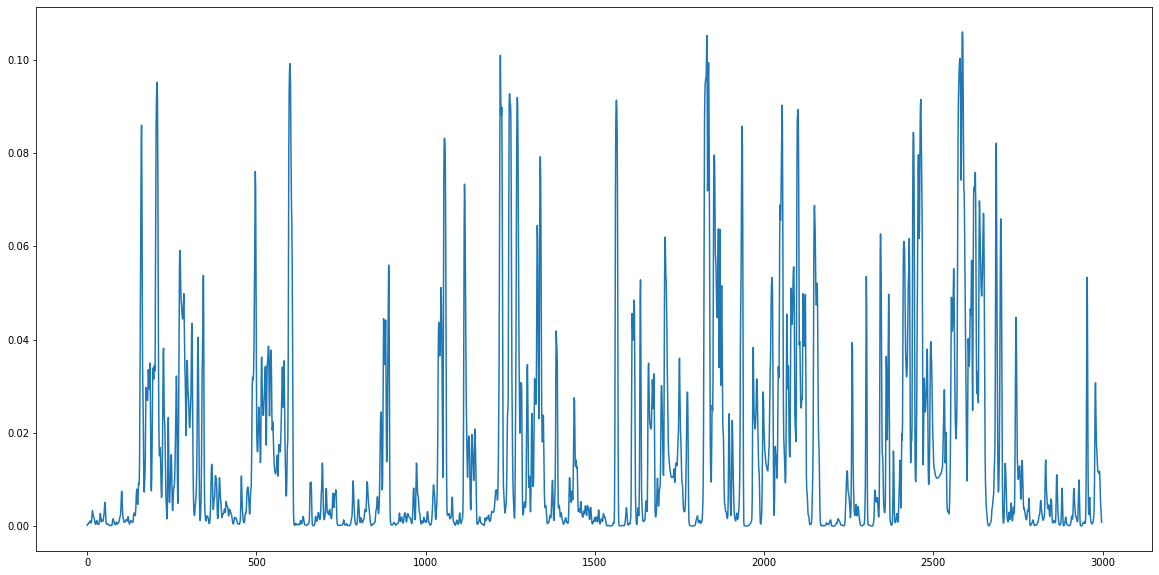

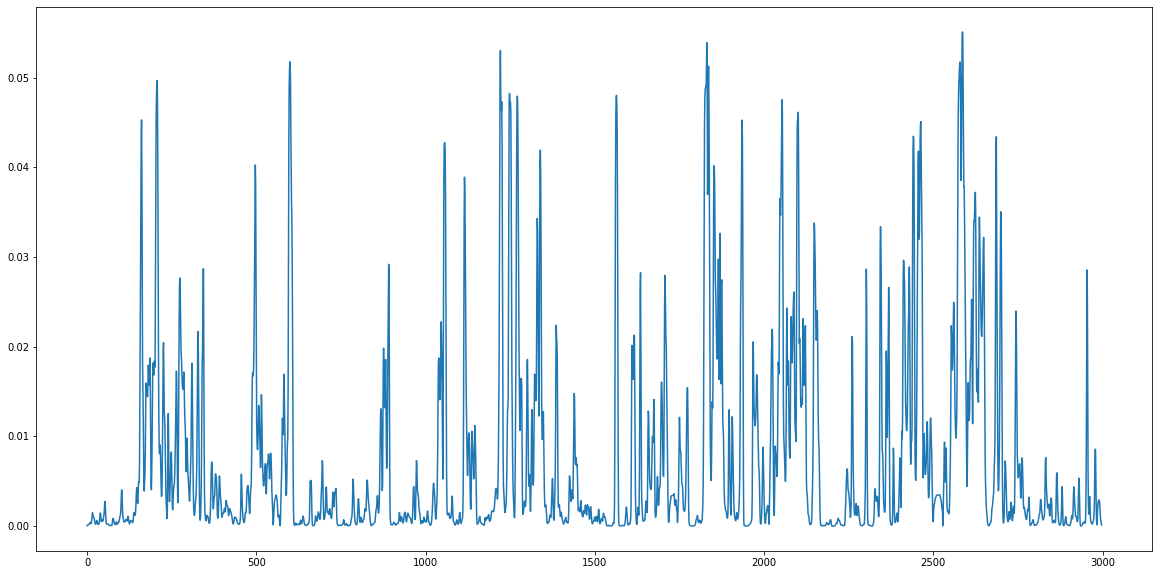

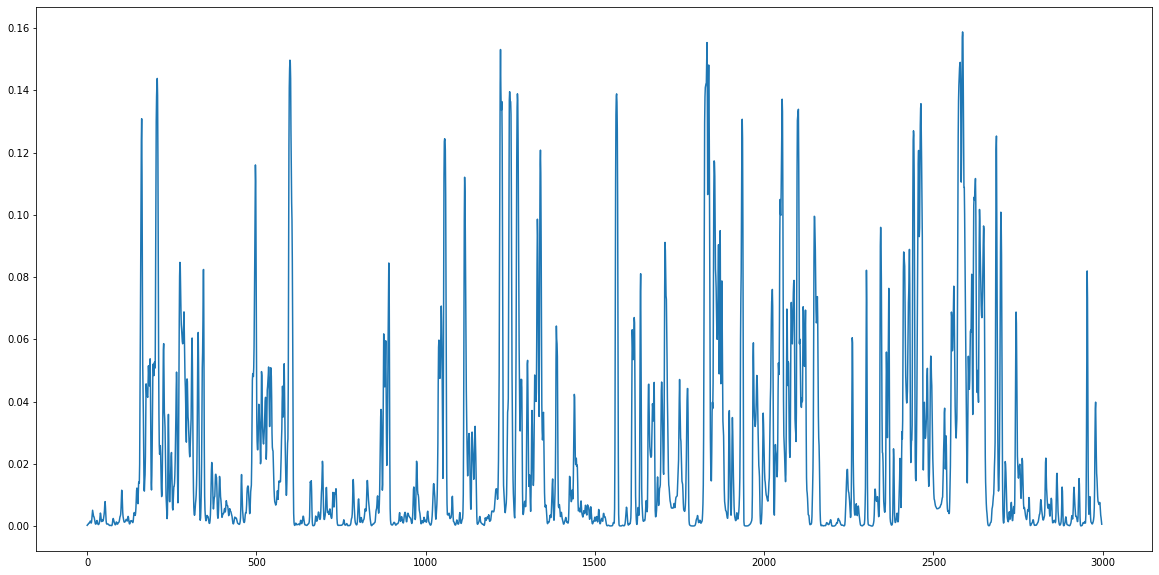

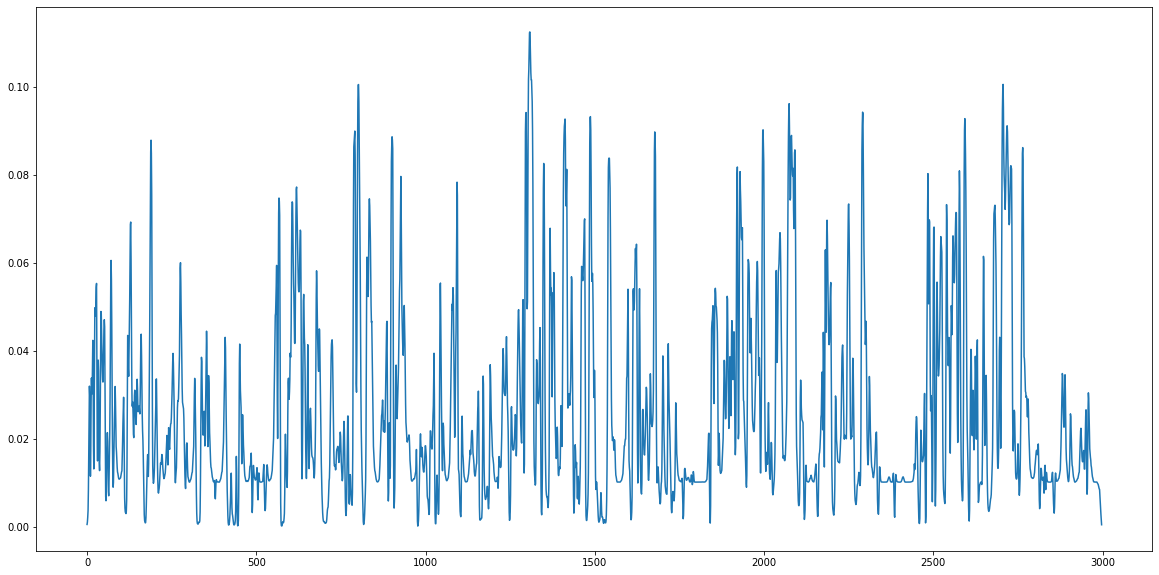

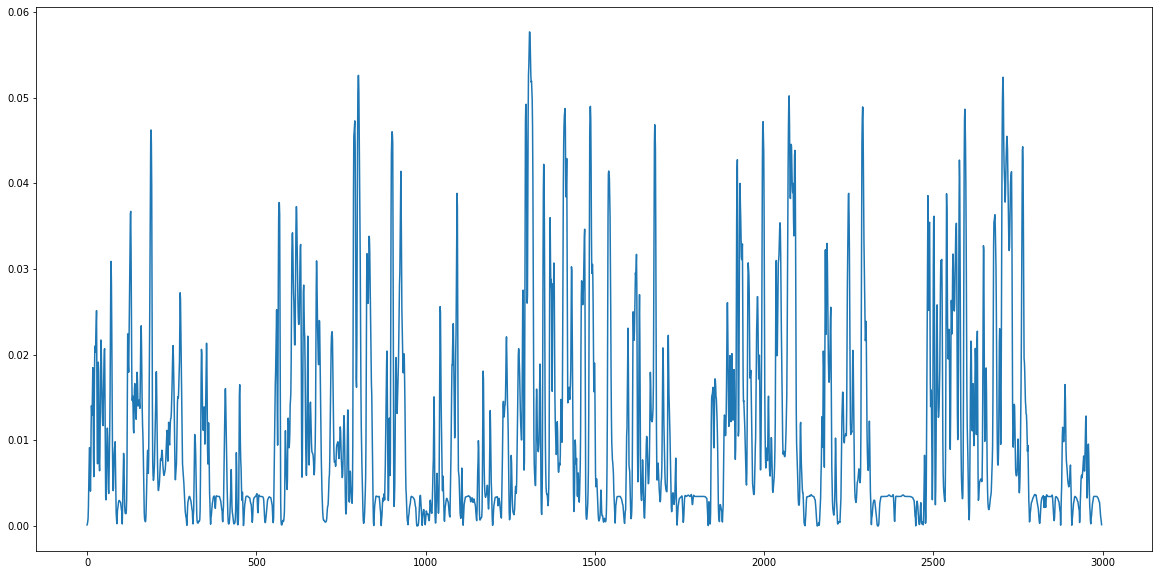

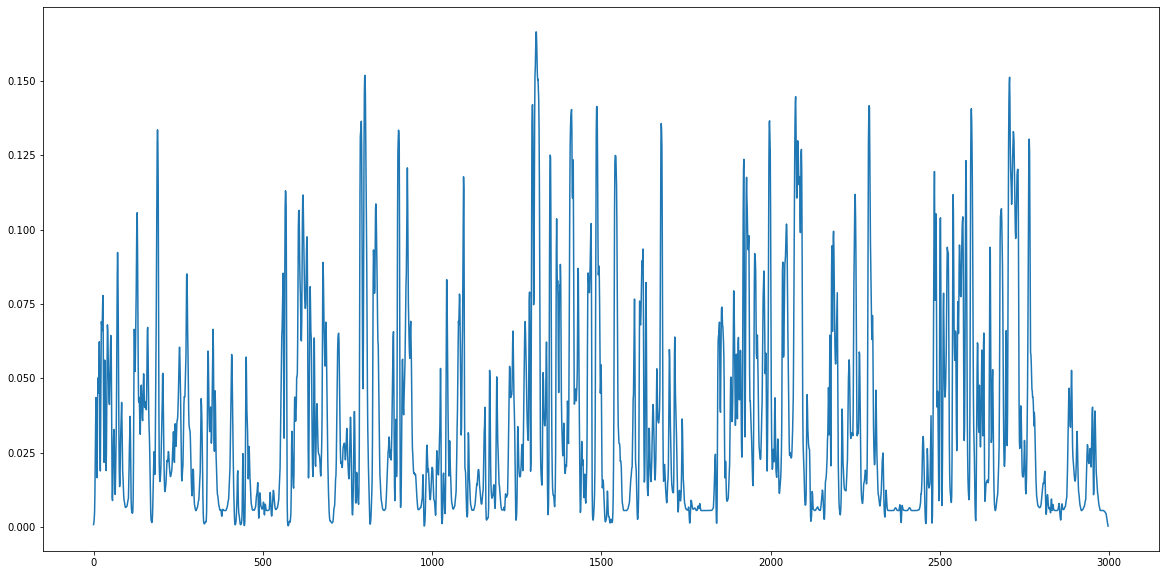

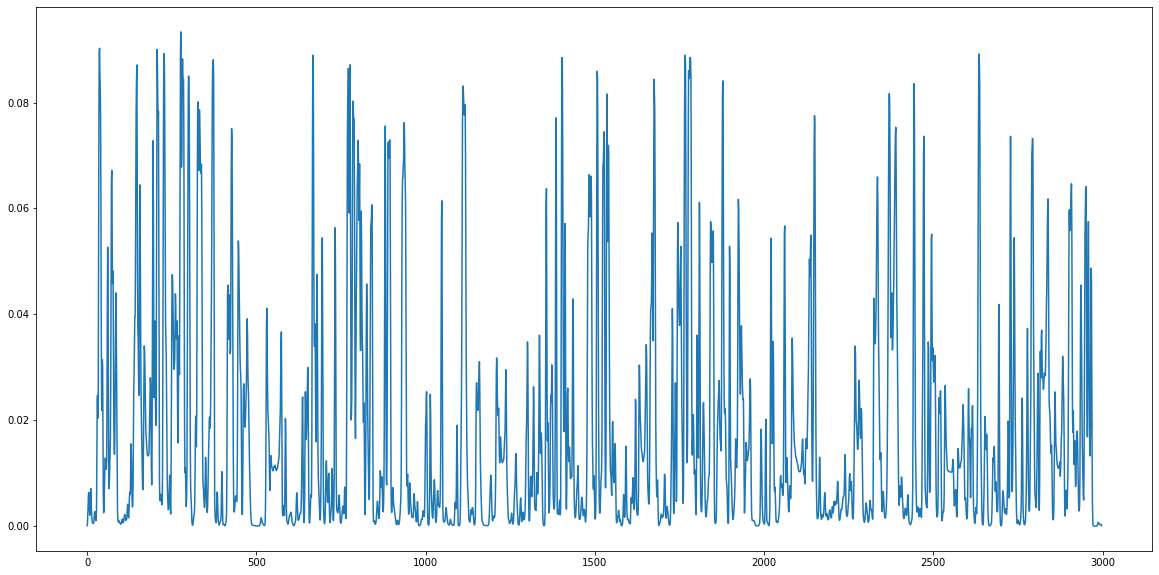

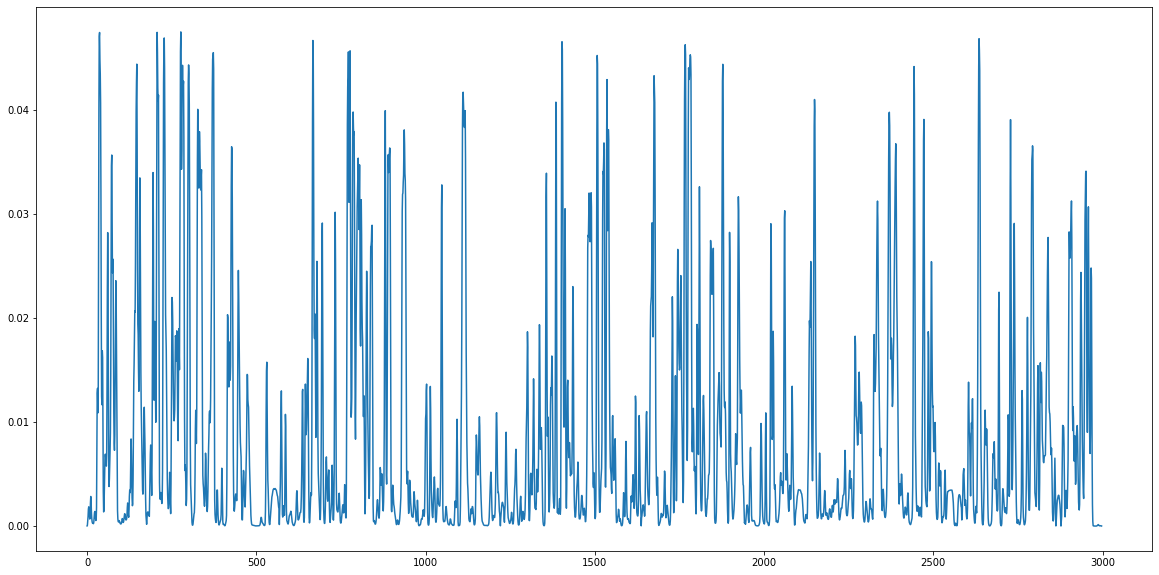

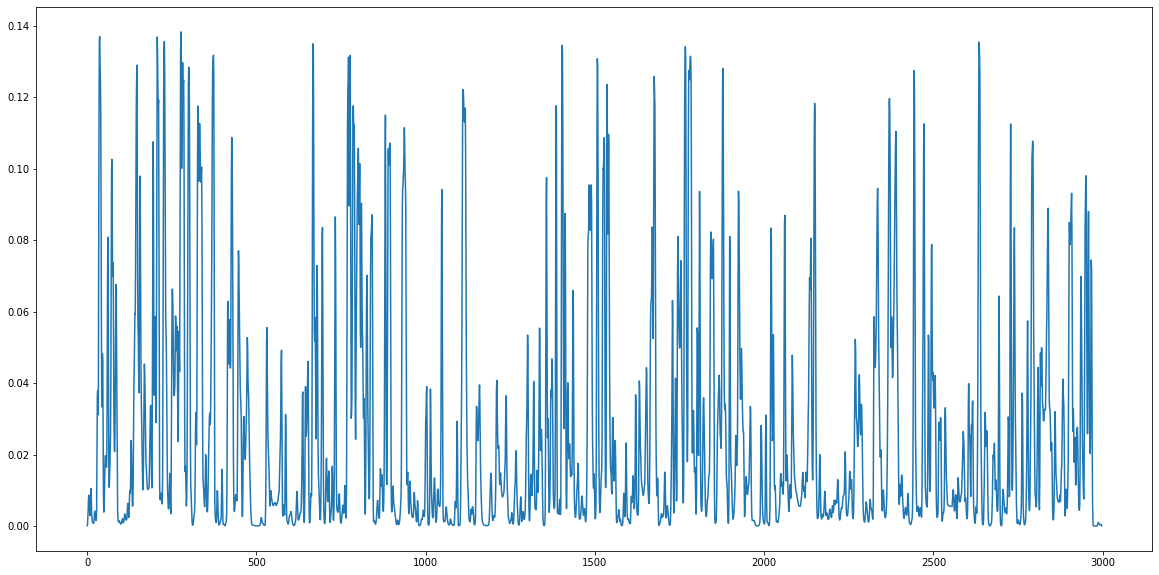

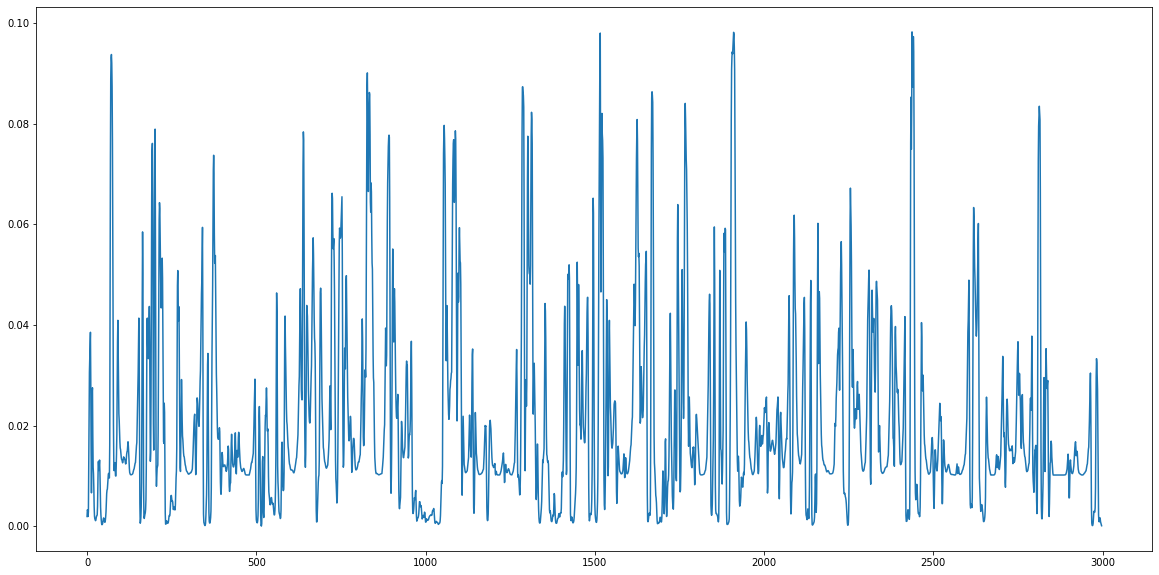

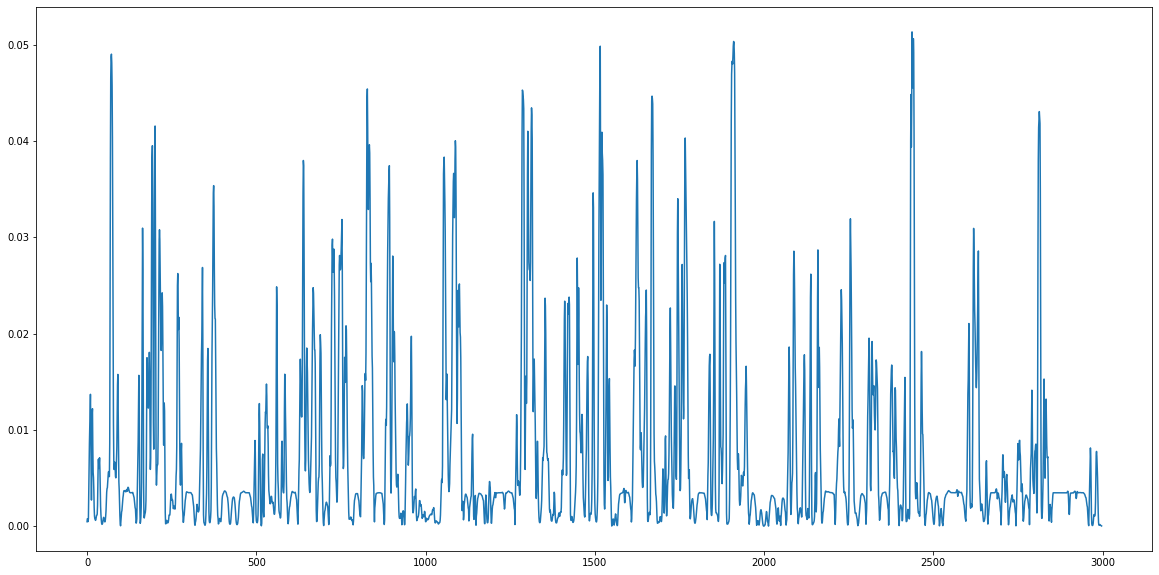

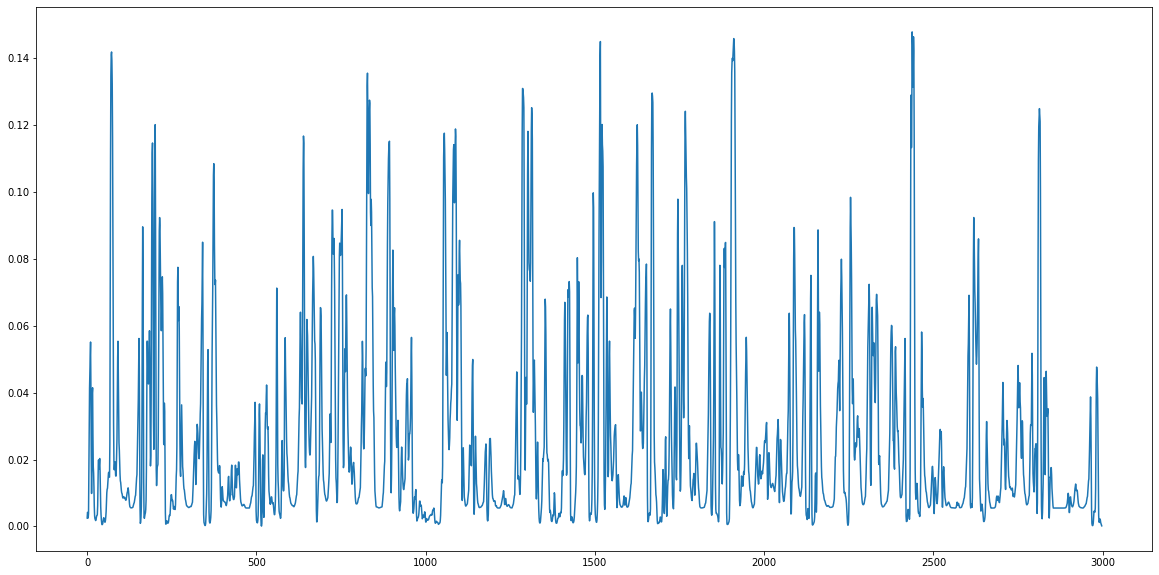

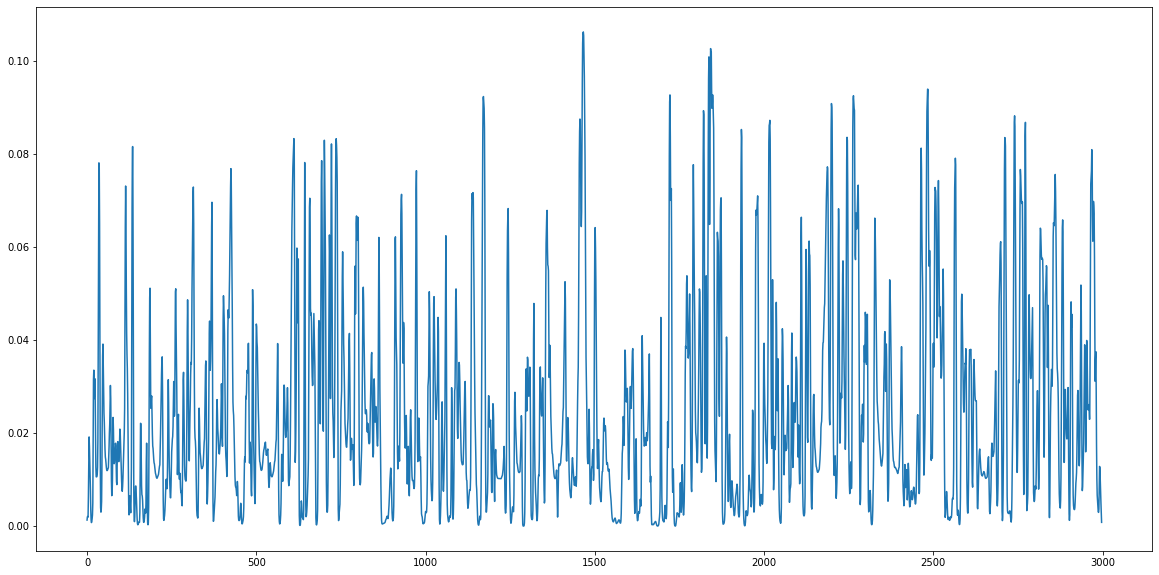

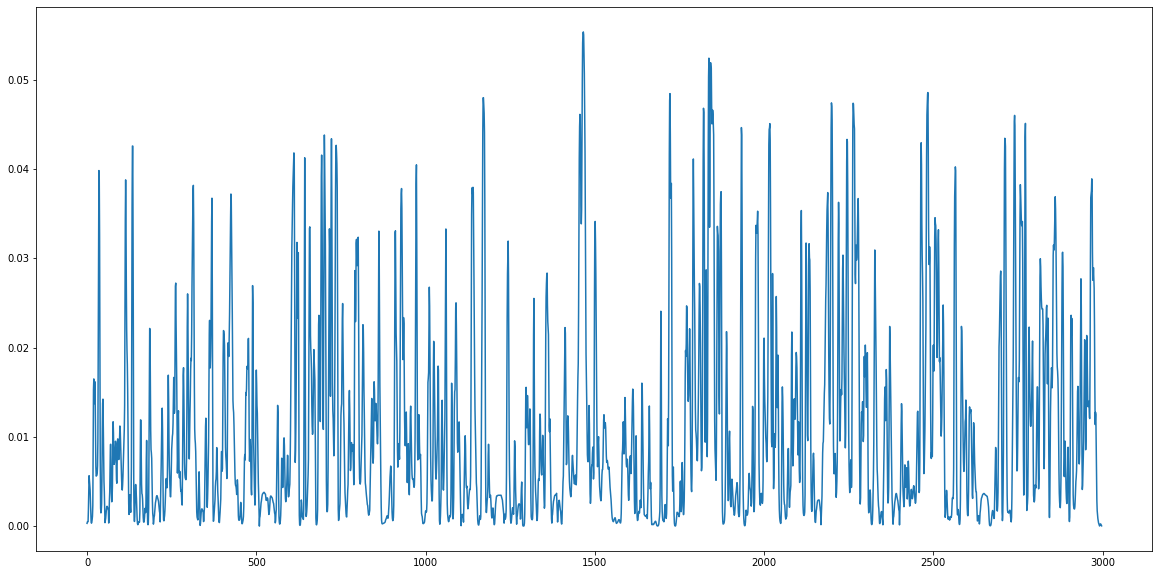

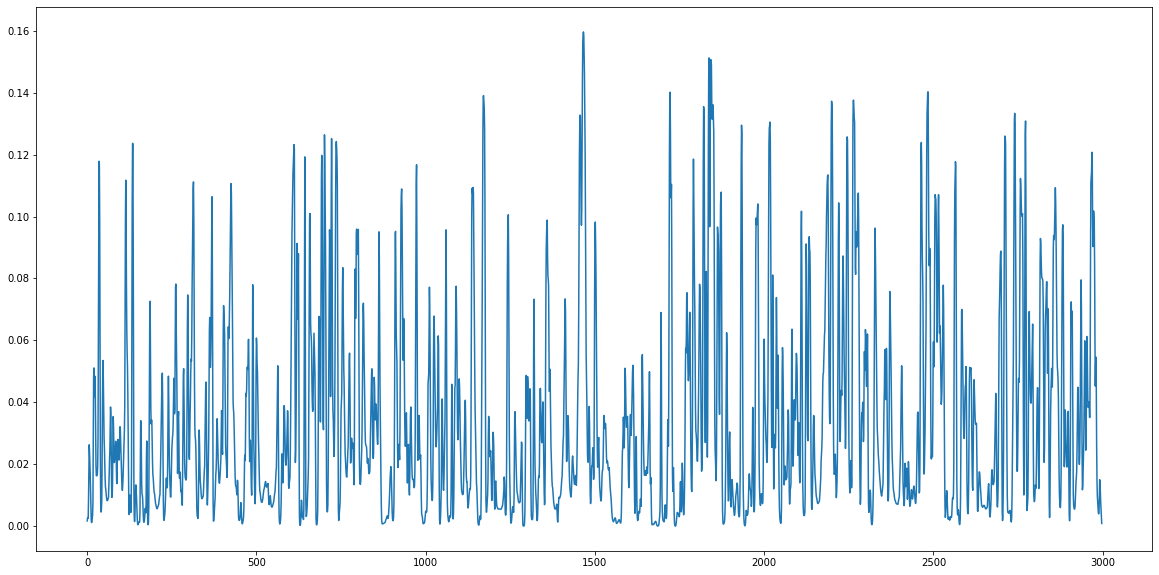

In [20]:
for i in range(data.shape[0]):
    x = data[i:i+1, :, :]
    visualize_attention(x, 0)
    visualize_attention(x, 1)
    visualize_attention(x, 2)